# Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support
from imblearn.over_sampling import SMOTE
from collections import Counter
import optuna
from optuna import trial
from optuna.visualization.matplotlib import plot_param_importances

# import stored variables from previous notebook
%store -r model_metrics_dict

# Load data

In [2]:
raw_data = pd.read_csv('../Data/Final/players_outfield_prepared.csv')
data = raw_data.copy()
df = pd.DataFrame(data)
pd.set_option('display.max_columns', None)
data.head()

,Age,Height,Weight,Overall,Potential,Growth,TotalStats,BaseStats,BestPosition,IntReputation,WeakFoot,SkillMoves,AttackingWorkRate,DefensiveWorkRate,PaceTotal,ShootingTotal,PassingTotal,DribblingTotal,DefendingTotal,PhysicalityTotal,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,STRating,LWRating,LFRating,CFRating,RFRating,RWRating,CAMRating,LMRating,CMRating,RMRating,LWBRating,CDMRating,RWBRating,LBRating,CBRating,RBRating,GKRating,Top_5_league
0,35,169,67,91,91,0,2190,452,0,5,4,4,1,1,81,89,90,94,34,64,84,90,70,91,88,95,93,93,90,93,87,76,91,92,95,86,68,70,68,91,44,40,93,94,75,96,20,35,24,6,11,15,14,8,90,90,91,91,91,90,91,91,88,91,67,66,67,62,53,62,22,1
1,34,185,81,91,91,0,2147,455,3,4,4,4,2,2,80,88,83,87,39,78,75,92,90,89,88,87,82,73,76,91,79,80,78,92,72,87,79,82,82,80,63,39,92,89,84,90,43,24,18,13,11,5,5,7,91,87,89,89,89,87,91,89,84,89,67,67,67,63,58,63,21,1
2,33,185,81,91,91,0,2205,458,13,5,4,4,0,2,75,91,79,86,44,83,71,94,91,84,89,85,79,85,70,89,76,75,77,93,82,91,85,76,87,84,81,49,94,81,90,88,35,42,19,15,6,12,8,10,91,85,88,88,88,85,88,86,83,86,67,69,67,64,63,64,22,1
3,31,181,70,91,91,0,2303,483,4,4,5,4,0,0,74,88,93,87,64,77,94,85,55,93,83,88,89,83,93,90,76,73,76,91,78,92,63,88,74,91,75,66,88,94,83,89,68,65,53,15,13,5,10,13,86,88,87,87,87,88,91,91,91,91,82,82,82,78,72,78,24,1
4,23,182,73,91,95,4,2177,470,13,4,4,5,0,1,97,89,80,92,36,76,78,93,72,85,83,93,80,69,71,91,97,97,93,93,81,88,77,87,76,82,64,38,92,83,80,88,26,34,32,13,5,7,11,6,92,90,90,90,90,90,92,92,84,92,70,66,70,66,57,66,21,1


In [3]:
# check shape
df.shape

(16478, 72)

In [4]:
# check balance of dataset
df['Top_5_league'].value_counts()

0    13908
1     2570
Name: Top_5_league, dtype: int64

# Remove features
- Only features that were determined to be useful (by way of having significant differences in mean and median values) will be included

In [5]:
df = df[['Overall', 'Potential', 'SkillMoves', 'PaceTotal', 'ShootingTotal',
       'PassingTotal', 'DribblingTotal', 'DefendingTotal', 'PhysicalityTotal',
       'Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys',
       'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Agility', 'Reactions',
       'ShotPower', 'LongShots','Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties',
       'Composure', 'Marking', 'StandingTackle', 'SlidingTackle', 'STRating',
       'LWRating', 'LFRating', 'CFRating', 'RFRating', 'RWRating', 'CAMRating',
       'LMRating', 'CMRating', 'RMRating', 'LWBRating', 'CDMRating',
       'RWBRating', 'LBRating', 'CBRating', 'RBRating','Top_5_league']]

df.head()

,Overall,Potential,SkillMoves,PaceTotal,ShootingTotal,PassingTotal,DribblingTotal,DefendingTotal,PhysicalityTotal,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Agility,Reactions,ShotPower,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,STRating,LWRating,LFRating,CFRating,RFRating,RWRating,CAMRating,LMRating,CMRating,RMRating,LWBRating,CDMRating,RWBRating,LBRating,CBRating,RBRating,Top_5_league
0,91,91,4,81,89,90,94,34,64,84,90,70,91,88,95,93,93,90,93,91,92,86,91,44,40,93,94,75,96,20,35,24,90,90,91,91,91,90,91,91,88,91,67,66,67,62,53,62,1
1,91,91,4,80,88,83,87,39,78,75,92,90,89,88,87,82,73,76,91,78,92,87,80,63,39,92,89,84,90,43,24,18,91,87,89,89,89,87,91,89,84,89,67,67,67,63,58,63,1
2,91,91,4,75,91,79,86,44,83,71,94,91,84,89,85,79,85,70,89,77,93,91,84,81,49,94,81,90,88,35,42,19,91,85,88,88,88,85,88,86,83,86,67,69,67,64,63,64,1
3,91,91,4,74,88,93,87,64,77,94,85,55,93,83,88,89,83,93,90,76,91,92,91,75,66,88,94,83,89,68,65,53,86,88,87,87,87,88,91,91,91,91,82,82,82,78,72,78,1
4,91,95,5,97,89,80,92,36,76,78,93,72,85,83,93,80,69,71,91,93,93,88,82,64,38,92,83,80,88,26,34,32,92,90,90,90,90,90,92,92,84,92,70,66,70,66,57,66,1


# Train test split

In [6]:
X = df.drop(['Top_5_league'], axis=1)
y = df['Top_5_league']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y, random_state=42)

# Balance the dataset: SMOTE

In [7]:
# instantiate
sm = SMOTE(random_state=42)

# use smote to create more samples
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)

### Visualise balanced dataset

Class=1, n=2570 (15.6%)
Class=0, n=13908 (84.4%)


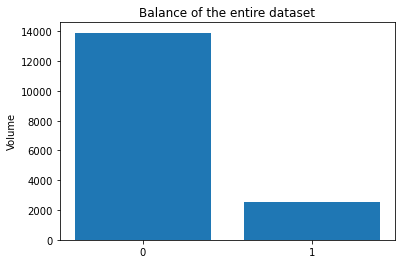

In [8]:
# get a count of the classes in the dataset
counter = Counter(y)

# visualise balance of entire dataset
for k,v in counter.items():
    percentage_of_total = v / len(y) * 100
    print(f"Class={k}, n={v} ({round(percentage_of_total, 2)}%)")

# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.title("Balance of the entire dataset")
plt.ylabel("Volume")
plt.xticks(ticks=np.arange(0, 2, step=1), labels=[0,1])
plt.show()

Class=0, n=11126 (84.4%)
Class=1, n=2056 (15.6%)


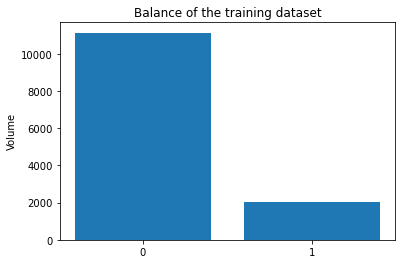

In [9]:
# get a count of the classes in the training dataset
counter = Counter(y_train)

# visualise balance of the training dataset

for k,v in counter.items():
    percentage_of_total = v / len(y_train) * 100
    print(f"Class={k}, n={v} ({round(percentage_of_total, 2)}%)")

# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.title("Balance of the training dataset")
plt.ylabel("Volume")
plt.xticks(ticks=np.arange(0, 2, step=1), labels=[0,1])

plt.show()

Class=0, n=11126 (50.0%)
Class=1, n=11126 (50.0%)


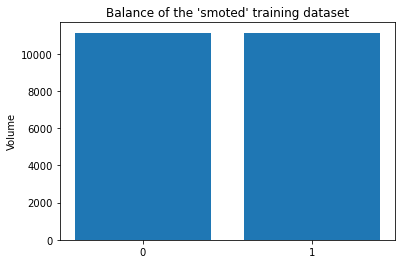

In [10]:
# get a count of the classes in the smoted training dataset
counter = Counter(y_train_smote)

# visualise balance of the smoted training dataset
for k,v in counter.items():
    percentage_of_total = v / len(y_train_smote) * 100
    print(f"Class={k}, n={v} ({round(percentage_of_total, 2)}%)")

# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.title("Balance of the 'smoted' training dataset")
plt.ylabel("Volume")
plt.xticks(ticks=np.arange(0, 2, step=1), labels=[0,1])

plt.show()

# Optuna

Create our objective function by defining:
* The search space (search parameters) using Optuna's _trial.suggest\__ method
* The model, with the above search parameters passed.
* The evaluation metric

In [11]:
def objective(trial=optuna.trial):
    
    """
    
    This function will return the desired evaluation metrics that will be passed to Optuna's optimize method for hyperparameter tuning.
    
    The function needs to define:
        * search space (hyperrparameters to be tuned)
        * the model to be used
        * the type of validation to be used (which returns one evaluation metric)
    
    """

    # set parameters
    param_grid = {'n_estimators': trial.suggest_int(name="n_estimators", low=10, high=2000), # number of trees to use in the ensemble
                  'learning_rate': trial.suggest_float(name="learning_rate", low=0.1, high=0.4), # Controls the step size at each iteration while moving towards the global minimum loss function
                  'max_depth': trial.suggest_int(name="max_depth", low=3, high=10), # set max depth of decision tree
                  'subsample': trial.suggest_float(name="subsample", low=0.3, high=1.0), # The fraction of training instances to use for each tree. Decreasing this can improve generalization but 
                  # can also decrease training speed.
                  'colsample_bytree': trial.suggest_float(name="colsample_bytree", low=0.2, high=1.0),
#                   'scale_pos_weight': [float(value_counts[0]/value_counts[1])], # Used for imbalanced classification tasks. Value should be set to the ratio of 
                  # negative class to positive class - not needed as SMOTE used to balance dataset
                  'min_child_weight': trial.suggest_float(name="min_child_weight", low=0.5, high=10), # The minimum sum of instance weight needed in a child. Increasing this value can reduce overfitting
                 }

    # instantiate xgb claassifier model
    xgb_model = xgb.XGBClassifier(**param_grid, random_state=42)
    
    # fit the model on the SMOTE balanced dataset
    xgb_model.fit(X_train_smote, y_train_smote)
    
    # make a prediction and get the f1 score
    y_pred = xgb_model.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    
    return f1

In [12]:
%%time
# instantiate a study session
study = optuna.create_study(direction='maximize', 
                            sampler=optuna.samplers.TPESampler(), # use Bayesian sampler (default) - options are GridSearch, RandomSearch,
                            # TPESampler or CmaEsSampler. TPE Sampler is used by default — it tries to sample hyperparameter candidates by
                            # improving on the last trial’s scores. In other words, you can expect incremental (maybe marginal) improvements 
                            # from trial to trial with this sampler
                            pruner=optuna.pruners.MedianPruner()) # purpose of a pruner is to save computational resources by stopping trials 
                            # that are unlikely to yield better results

study.optimize(objective, n_trials=100)

[I 2023-05-31 22:44:07,686] A new study created in memory with name: no-name-9183c67c-fe71-4ae4-9ce7-2d647c16a6dd
[I 2023-05-31 22:44:16,996] Trial 0 finished with value: 0.594547053649956 and parameters: {'n_estimators': 514, 'learning_rate': 0.34091090000452595, 'max_depth': 5, 'subsample': 0.7983526187341852, 'colsample_bytree': 0.2577156485909382, 'min_child_weight': 8.649784971009762}. Best is trial 0 with value: 0.594547053649956.
[I 2023-05-31 22:46:08,575] Trial 1 finished with value: 0.6303142329020333 and parameters: {'n_estimators': 1521, 'learning_rate': 0.277581891859453, 'max_depth': 8, 'subsample': 0.9718366649390096, 'colsample_bytree': 0.924886082710014, 'min_child_weight': 7.346218285837894}. Best is trial 1 with value: 0.6303142329020333.
[I 2023-05-31 22:47:34,462] Trial 2 finished with value: 0.6080717488789238 and parameters: {'n_estimators': 1291, 'learning_rate': 0.35128431632496615, 'max_depth': 10, 'subsample': 0.3306495407531144, 'colsample_bytree': 0.8281704

CPU times: user 2h 7min 2s, sys: 4min 15s, total: 2h 11min 17s
Wall time: 3h 57min 10s


In [13]:
# get bet hyperparameters
study.best_params

{'n_estimators': 602,
 'learning_rate': 0.12912936873558822,
 'max_depth': 9,
 'subsample': 0.5844864510861869,
 'colsample_bytree': 0.20162112054991022,
 'min_child_weight': 0.8440882688795204}

<ipython-input-14-621aa90d3b6a>:2: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(study)


<AxesSubplot:title={'center':'Hyperparameter Importances'}, xlabel='Importance for Objective Value', ylabel='Hyperparameter'>

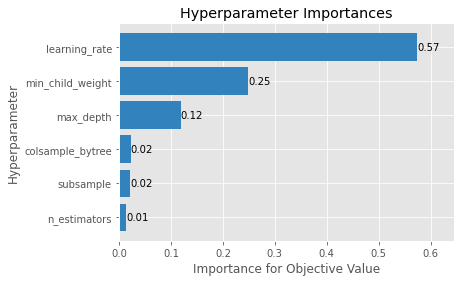

In [14]:
# view the importance of the hyperparameters
plot_param_importances(study)

In [15]:
# define model using the tuned parameters
xgb_model = xgb.XGBClassifier(n_estimators=570,
                              learning_rate=0.18088580625997563,
                              max_depth=9,
                              subsample=0.7605632647637218,
                              colsample_bytree=0.7783287797979347,
                              min_child_weight=0.5794713914942553,
                              random_state=42)

# fit model
xgb_model.fit(X_train_smote, y_train_smote)

# Use the best model to make predictions on the test set
xgb_predictions = xgb_model.predict(X_test)

# Evaluate Model

In [16]:
# Calculate and print the accuracy of the model
accuracy = accuracy_score(y_true=y_test, y_pred=xgb_predictions)
print("Accuracy:", accuracy)

Accuracy: 0.8880461165048543


## Confusion Matrix

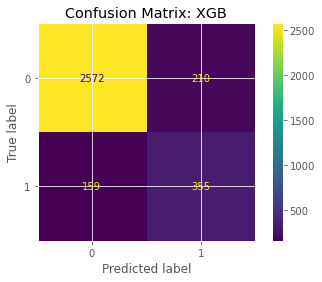

In [17]:
cm = confusion_matrix(y_true=y_test, y_pred=xgb_predictions, labels=xgb_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_model.classes_)
disp.plot()
plt.title("Confusion Matrix: XGB")
plt.show()

In [18]:
print(classification_report(y_true=y_test, y_pred=xgb_predictions))

              precision    recall  f1-score   support

           0       0.94      0.92      0.93      2782
           1       0.63      0.69      0.66       514

    accuracy                           0.89      3296
   macro avg       0.79      0.81      0.80      3296
weighted avg       0.89      0.89      0.89      3296



# Compare models

In [19]:
# create a dataframe to allow quick comparison of models (add more models to the dictionary as they are created)
metrics = precision_recall_fscore_support(y_true=y_test, y_pred=xgb_predictions)

# Extract precision, recall, f1-score, and support and round to two decimal places
precision = [round(p, 2) for p in metrics[0]]
recall = [round(r, 2) for r in metrics[1]]
f1_score = [round(f, 2) for f in metrics[2]]
support = metrics[3]

# update dictionary to include new model
model_metrics_dict['XGB_SMOTE_Optuna'] = {
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1_score,
        "Accuracy": round(accuracy, 2),
        "Support": support,
}

In [20]:
# create dataframe from model metrics dictionary - values will be displayed as a list of negative and positive class data
df_report = pd.DataFrame(data=model_metrics_dict)
# rename the index column to 'metric'
df_report.index.rename('Metric', inplace=True)
# reset the index so there is a standard numerical index
df_report.reset_index(inplace=True)
# check output
df_report

,Metric,XGB_Baseline,XGB_Tuned_Random_Search,XGB_Baseline_SMOTE,XGB_SMOTE_Optuna
0,Precision,"[0.92, 0.73]","[0.96, 0.46]","[0.94, 0.56]","[0.94, 0.63]"
1,Recall,"[0.96, 0.56]","[0.82, 0.82]","[0.9, 0.7]","[0.92, 0.69]"
2,F1 Score,"[0.94, 0.64]","[0.89, 0.59]","[0.92, 0.62]","[0.93, 0.66]"
3,Accuracy,0.9,0.82,0.87,0.89
4,Support,"[2782, 514]","[2782, 514]","[2782, 514]","[2782, 514]"


## Store variables

In [21]:
%store model_metrics_dict

Stored 'model_metrics_dict' (dict)
